### Credits:

## Problem 3.2: Pulsing jellyfish (50 pts)

In [Tutorial 3b](../tutorials/t3b_extracting_info_from_images.html), we extracted information from movies of pulsing jellyfish. Using these images (which you can download [here](../data/cassiopea_pulsation.zip), analyze both the daytime and nighttime movies. Compare and contrast the measurements both between daytime and nighttime and among the individual jellyfish. Discuss any conclusions or suggestions for further experiments you may have.

*This question is intentionally open-ended. Think carefully about what you want to do and how you interpret what you see.*

## Solution

In [85]:
import glob
import os
import sys

import numpy as np
import pandas as pd

import scipy.signal
# Import Altair for high level plotting
import altair as alt
import altair_catplot as altcat

# Image processing tools
import skimage
import skimage.io

import bebi103
import bokeh
from bokeh.models import Legend, LegendItem
bokeh.io.output_notebook()

Loading BokehJS ...

The first step to analyzing this data is loading it, defining ROIs, and plotting the frequencies. My annotations of this process will be sparse because it is taken verbatum from tutorial 3b. 

First I will get filenames for image data.

In [2]:
# The directory containing daytime data
data_dir_day = '../data/Cassiopea_Pulsation/day'
data_dir_night = '../data/Cassiopea_Pulsation/night'

# Glob string for images
im_glob_day = os.path.join(data_dir_day, '*.TIF')
im_glob_night = os.path.join(data_dir_night, '*.TIF')

# Get list of files in directory
im_list_day = sorted(glob.glob(im_glob_day))
im_list_night = sorted(glob.glob(im_glob_night))

# Check to make sure we have the right filenames.
im_list_night[:5]

['../data/Cassiopea_Pulsation/night/Frame_545000.TIF',
 '../data/Cassiopea_Pulsation/night/Frame_545001.TIF',
 '../data/Cassiopea_Pulsation/night/Frame_545002.TIF',
 '../data/Cassiopea_Pulsation/night/Frame_545003.TIF',
 '../data/Cassiopea_Pulsation/night/Frame_545004.TIF']

The filenames look good. Brief validation that the images are greyscale was performed in the tutorial, so I will assume that here, and efficiently load the images as an image collection using sci-kit image and tutorial code. 

In [3]:
def squish_rgb(fname, **kwargs):
    """
    Only take one channel. (Need to explicitly have the **kwargs to play
    nicely with skimage.io.ImageCollection.)
    """
    im = skimage.io.imread(fname)
    return im[:,:,0]

# Load in day images
ic_day = skimage.io.ImageCollection(im_glob_day,
                                    conserve_memory=True, 
                                    load_func=squish_rgb)

# Load in night images
ic_night = skimage.io.ImageCollection(im_glob_night,
                                      conserve_memory=True, 
                                      load_func=squish_rgb)

I will also make time series for both image collections, assuming again that the rate is 15 frames per second. 

In [4]:
fps = 15
t_day = np.arange(0, len(ic_day)) / fps
t_night = np.arange(0, len(ic_night)) / fps
t_night, t_day

(array([0.00000000e+00, 6.66666667e-02, 1.33333333e-01, ...,
        2.66466667e+02, 2.66533333e+02, 2.66600000e+02]),
 array([0.00000000e+00, 6.66666667e-02, 1.33333333e-01, ...,
        2.66466667e+02, 2.66533333e+02, 2.66600000e+02]))

Looks like both datasets are about 267 seconds long, which seems reasonable. 

Dr. Bois said that the jellyfish will not shift during the experiment, for which we are very thankful. Thus, we will draw a set of ROIs for each image collection, one ROI per jellyfish. 

The following code checks to see if there is already an ROI file, and prompts you to draw rois if there is not. Otherwise, it simply loads the ROIs into a dataframe. 

In [5]:
df_rois = None
try:
    df_rois = pd.read_csv("./roi_dataframe.csv")
    df_rois = df_rois.drop(["Unnamed: 0"], axis = 1)
except:
    print("ROIs not found. Please draw ROIs, or place them in the appropriate directory.")
    # Read in the first images using skimage
    im_day = skimage.io.imread(im_list_day[0])

    # Draw day ROIs
    print("Please draw day ROIs.")
    rois_day = bebi103.viz.draw_rois(im_day, flip=False)

Now to draw night ROIs, if not already drawn. 

In [6]:
if type(df_rois) == type(None):
    print("Please draw night ROIs before executing the next cell.")
    im_night = skimage.io.imread(im_list_day[0])
    rois_night = bebi103.viz.draw_rois(im_night, flip=False)

Looks great! Now it is time to add night/day fields and save the ROIs as a csv, so that you never ever ever ever have to draw them again. 

In [7]:
if type(df_rois) == type(None):
    # Turn the ROIs into dataframes
    df_rois_day = bebi103.viz.roicds_to_df(rois_day)
    df_rois_night = bebi103.viz.roicds_to_df(rois_night)
    
    # Add a day or a night column
    daytime_arr = ["day"] * len(df_rois_day.index)
    nighttime_arr = ["night"] * len(df_rois_night.index)
    df_rois_day["time_of_day"] = daytime_arr
    df_rois_night["time_of_day"] = nighttime_arr
    
    # Save ROIs as a .csv
    df_rois = pd.concat([df_rois_day, df_rois_night])
    df_rois.to_csv(path_or_buf="./roi_dataframe.csv")

Lets take a look at our new roi dataframe:

In [8]:
df_rois.head()

roi           x           y time_of_day
0    0  545.587583  331.660714         day
1    0  579.534368  318.701786         day
2    0  588.575388  279.182143         day
3    0  580.260532  244.328571         day
4    0  512.400222  246.358929         day

Now I want to begin the process of transforming these image series into a simple timeseries of intensity values within the roi. First I will obtain an the parameters of all the ROIs, such as the bounding box. 

In [9]:
im_night = skimage.io.imread(im_list_night[0])
im_day = skimage.io.imread(im_list_day[0])

# Manually reduce image dimensionality. 
im_day = im_day[:,:,0]
im_night = im_night[:,:,0]

# Obtain the ROI parameters for all ROIs using a streamlined  function from bebi103. 
rois_day = [bebi103.image.verts_to_roi(g[['x', 'y']].values, *im_day.shape)
            for _, g in df_rois[df_rois['time_of_day']=='day'].groupby('roi')]

rois_night = [bebi103.image.verts_to_roi(g[['x', 'y']].values, *im_night.shape)
            for _, g in df_rois[df_rois['time_of_day']=='night'].groupby('roi')]

I need to define the loading function for loading only the roi portion of an image. This will make the caclulation of pixel intensities across the image collection much faster. 

In [10]:
# Define load_func that only gives region bounding ROI
def load_roi(fname, roi_bbox=None, **kwargs):
    """
    Image loading function to only load ROI.
    """
    if roi_bbox is None:
        return skimage.io.imread(fname)[:,:,0]
    else:
        return skimage.io.imread(fname)[:,:,0][roi_bbox]

This next cell will take some time to run; it loops through all the ROIs, finds the total pixel intensity within the roi at each timepoint, and saves the value in a dataframe. Since it is a computation-heavy cell, I'm going to save the output permanently, and keep it in a try block. 

In [11]:
df_roi_intensities = None
try:
    # This executes if we have already done the computation
    df_roi_intensities = pd.read_csv("./roi_intensities_all.csv")
    df_roi_intensities = df_roi_intensities.drop(["Unnamed: 0"], axis = 1)
except:
    # Here comes the computation
    
    # This will be used to store the pixel intensity over time. 
    df_roi_intensities = pd.DataFrame(t_day, columns = ["time"])

    # I'm looping through all the rois, and creating an array that stores
    # pixel-intensity over time. This loop works because both day and night
    # have the same number of rois. 
    for roi in set(df_rois["roi"].values): # set reduces the array to unique values
        # Establish the ROI parameters
        roi_day, roi_bbox_day, roi_box_day = rois_day[roi]
        roi_night, roi_bbox_night, roi_box_night = rois_night[roi]

        # I now need to re-load the image collections using the roi box as a bound. 
        ic_day = skimage.io.ImageCollection(im_glob_day, conserve_memory=True, 
                                            load_func=load_roi, roi_bbox=roi_bbox_day)
        ic_night = skimage.io.ImageCollection(im_glob_night, conserve_memory=True, 
                                              load_func=load_roi, roi_bbox=roi_bbox_night)

        # Set up NumPy array to store total pixel intensity
        total_int_day = np.empty(len(t_day))
        total_int_night = np.empty(len(t_night))

        # Look through and compute total intensity in the ROI
        for i, im in enumerate(ic_day):
            total_int_day[i] = ic_day[i][roi_box_day].sum()
        for i, im in enumerate(ic_night):
            total_int_night[i] = ic_night[i][roi_box_night].sum()

        # Append pixel intensities over time to the dataframe we started with
        df_roi_intensities["sum_int_day_roi%i"%roi] = total_int_day
        df_roi_intensities["sum_int_night_roi%i"%roi] = total_int_night

        # Save the result permenantly, so as not to waste computation time in the future
        df_roi_intensities.to_csv("./roi_intensities_all.csv")

That was a non-trivial code block, but we are really close to finally being able to visualize this dataset! Let's check the dataframe to make sure it looks like it should.

In [12]:
df_roi_intensities.head()

time  sum_int_day_roi0  sum_int_night_roi0  sum_int_day_roi1  \
0  0.000000        23672784.0         192287143.0        87708446.0   
1  0.066667        30173085.0         188121173.0        87413153.0   
2  0.133333        33928369.0         182887368.0        88626450.0   
3  0.200000        34444425.0         177149586.0        93134230.0   
4  0.266667        34307444.0         174527415.0       101967834.0   

   sum_int_night_roi1  sum_int_day_roi2  sum_int_night_roi2  sum_int_day_roi3  \
0          23579750.0        20381642.0          93182289.0        49394372.0   
1          23070119.0        20426103.0          90366340.0        54911134.0   
2          23135397.0        20208938.0          89132740.0        59444100.0   
3          23155443.0        20125413.0          88562457.0        61832915.0   
4          23684863.0        20187350.0          89533403.0        61913613.0   

   sum_int_night_roi3  sum_int_day_roi4  sum_int_night_roi4  sum_int_day_roi5  \
0         134986166.0        62376470.0          69707652.0        18470333.0   
1         142097099.0        61265973.0          68748014.0        17327711.0   
2         147009397.0        64376701.0          68772943.0        16262446.0   
3         145832337.0        69722558.0          68884738.0        15510464.0   
4         144701280.0        72836370.0          69930471.0        14982843.0   

   sum_int_night_roi5  sum_int_day_roi6  sum_int_night_roi6  sum_int_day_roi7  \
0         211597095.0        38229264.0         123431960.0        38857629.0   
1         208951280.0        37591647.0         119713684.0        39817781.0   
2         207424186.0        36083057.0         118003092.0        39922894.0   
3         207352226.0        33953812.0         117067869.0        44692557.0   
4         209495606.0        30690426.0         117923165.0        56251903.0   

   sum_int_night_roi7  
0         127732855.0  
1         123506233.0  
2         120658416.0  
3         118551273.0  
4         119009504.0

I need to normalize the data so that each plot may be accurately compared. 

In [42]:
# Data not tidy

# Index by time, compress, sort, and index by the top level 
df_tidy_roi_int = df_roi_intensities.set_index(['time']).stack(level=0)
df_tidy_roi_int = df_tidy_roi_int.sort_index(level=1)
df_tidy_roi_int = df_tidy_roi_int.reset_index(level=1)

# Make time a column again
df_tidy_roi_int = df_tidy_roi_int.reset_index(level=0)

# Separate the compressed indices data into its own dataframe, split into separate columns
new_indices = df_tidy_roi_int.level_1.str.split("_").apply(pd.Series)

# Drop unnecessary columns
new_indices = new_indices.drop(columns = [0,1])
df_tidy_roi_int = df_tidy_roi_int.drop(columns = ['level_1',])

# Make index its own column so there's a shared column and merge
new_indices = new_indices.reset_index(level=0)
df_tidy_roi_int = df_tidy_roi_int.reset_index(level=0)
df_tidy_roi_int = pd.merge(df_tidy_roi_int, new_indices)


# Give the columns useful names
df_tidy_roi_int = df_tidy_roi_int.rename(columns={0:'sum_int', 2: 'Condition', 
                                  3:'ROI'})

# Get rid of the ROI letters
df_tidy_roi_int["ROI"] = df_tidy_roi_int.ROI.str[3:4]
df_tidy_roi_int["ROI"] = df_tidy_roi_int['ROI'].astype(int)

# Reorganizing the columns, dropping redundant index column
df_tidy_roi_int = df_tidy_roi_int[['time','Condition','ROI','sum_int']]

# Now I will make roi values unique, to save me from later headaches
# ROI will now range from 0 to 15. 
df_tidy_roi_int["ROI"] = df_tidy_roi_int["ROI"].values \
                         + (df_tidy_roi_int["Condition"]=="night")*8

df_tidy_roi_int.head()

time Condition  ROI     sum_int
0  0.000000       day    0  23672784.0
1  0.066667       day    0  30173085.0
2  0.133333       day    0  33928369.0
3  0.200000       day    0  34444425.0
4  0.266667       day    0  34307444.0

NOW we can normalize

In [63]:
# We need to define the mean, max, and min for each ROI
roi = range(0, 16)
d_temp = pd.DataFrame({"ROI" : range(0, 16)})

means = np.empty([0])
mins = np.empty([0])
maxes = np.empty([0])
for r in range(0, 16):
    sub_df = df_tidy_roi_int[df_tidy_roi_int["ROI"]==r]
    means = np.append(means, np.average(sub_df["sum_int"].values))
    mins = np.append(mins, np.min(sub_df["sum_int"].values))
    maxes = np.append(maxes, np.max(sub_df["sum_int"].values))
d_temp["mean"] = means
d_temp["min"] = mins
d_temp["max"] = maxes
df_tidy_roi_int = pd.merge(d_temp, df_tidy_roi_int)
df_tidy_roi_int.head()

ROI          mean         min         max      time Condition     sum_int
0    0  2.850655e+07  19847853.0  36886182.0  0.000000       day  23672784.0
1    0  2.850655e+07  19847853.0  36886182.0  0.066667       day  30173085.0
2    0  2.850655e+07  19847853.0  36886182.0  0.133333       day  33928369.0
3    0  2.850655e+07  19847853.0  36886182.0  0.200000       day  34444425.0
4    0  2.850655e+07  19847853.0  36886182.0  0.266667       day  34307444.0

In [70]:
df_tidy_roi_int

ROI          mean          min          max        time Condition  \
0        0  2.850655e+07   19847853.0   36886182.0    0.000000       day   
1        0  2.850655e+07   19847853.0   36886182.0    0.066667       day   
2        0  2.850655e+07   19847853.0   36886182.0    0.133333       day   
3        0  2.850655e+07   19847853.0   36886182.0    0.200000       day   
4        0  2.850655e+07   19847853.0   36886182.0    0.266667       day   
5        0  2.850655e+07   19847853.0   36886182.0    0.333333       day   
6        0  2.850655e+07   19847853.0   36886182.0    0.400000       day   
7        0  2.850655e+07   19847853.0   36886182.0    0.466667       day   
8        0  2.850655e+07   19847853.0   36886182.0    0.533333       day   
9        0  2.850655e+07   19847853.0   36886182.0    0.600000       day   
10       0  2.850655e+07   19847853.0   36886182.0    0.666667       day   
11       0  2.850655e+07   19847853.0   36886182.0    0.733333       day   
12       0  2.850655e+07   19847853.0   36886182.0    0.800000       day   
13       0  2.850655e+07   19847853.0   36886182.0    0.866667       day   
14       0  2.850655e+07   19847853.0   36886182.0    0.933333       day   
15       0  2.850655e+07   19847853.0   36886182.0    1.000000       day   
16       0  2.850655e+07   19847853.0   36886182.0    1.066667       day   
17       0  2.850655e+07   19847853.0   36886182.0    1.133333       day   
18       0  2.850655e+07   19847853.0   36886182.0    1.200000       day   
19       0  2.850655e+07   19847853.0   36886182.0    1.266667       day   
20       0  2.850655e+07   19847853.0   36886182.0    1.333333       day   
21       0  2.850655e+07   19847853.0   36886182.0    1.400000       day   
22       0  2.850655e+07   19847853.0   36886182.0    1.466667       day   
23       0  2.850655e+07   19847853.0   36886182.0    1.533333       day   
24       0  2.850655e+07   19847853.0   36886182.0    1.600000       day   
25       0  2.850655e+07   19847853.0   36886182.0    1.666667       day   
26       0  2.850655e+07   19847853.0   36886182.0    1.733333       day   
27       0  2.850655e+07   19847853.0   36886182.0    1.800000       day   
28       0  2.850655e+07   19847853.0   36886182.0    1.866667       day   
29       0  2.850655e+07   19847853.0   36886182.0    1.933333       day   
...    ...           ...          ...          ...         ...       ...   
63970   15  1.220731e+08  112931197.0  135363956.0  264.666667     night   
63971   15  1.220731e+08  112931197.0  135363956.0  264.733333     night   
63972   15  1.220731e+08  112931197.0  135363956.0  264.800000     night   
63973   15  1.220731e+08  112931197.0  135363956.0  264.866667     night   
63974   15  1.220731e+08  112931197.0  135363956.0  264.933333     night   
63975   15  1.220731e+08  112931197.0  135363956.0  265.000000     night   
63976   15  1.220731e+08  112931197.0  135363956.0  265.066667     night   
63977   15  1.220731e+08  112931197.0  135363956.0  265.133333     night   
63978   15  1.220731e+08  112931197.0  135363956.0  265.200000     night   
63979   15  1.220731e+08  112931197.0  135363956.0  265.266667     night   
63980   15  1.220731e+08  112931197.0  135363956.0  265.333333     night   
63981   15  1.220731e+08  112931197.0  135363956.0  265.400000     night   
63982   15  1.220731e+08  112931197.0  135363956.0  265.466667     night   
63983   15  1.220731e+08  112931197.0  135363956.0  265.533333     night   
63984   15  1.220731e+08  112931197.0  135363956.0  265.600000     night   
63985   15  1.220731e+08  112931197.0  135363956.0  265.666667     night   
63986   15  1.220731e+08  112931197.0  135363956.0  265.733333     night   
63987   15  1.220731e+08  112931197.0  135363956.0  265.800000     night   
63988   15  1.220731e+08  112931197.0  135363956.0  265.866667     night   
63989   15  1.220731e+08  112931197.0  135363956.0  265.933333     night   
63990   15  1.220731e+08  112931197.0  135363956.0  266

In [76]:
def normalize_int(index):
    
    # Set up Boolean slicing
    daytime = df_tidy_roi_int['Condition'] == df_tidy_roi_int['Condition'].iloc[index]
    jellyfish = df_tidy_roi_int['ROI'] == df_tidy_roi_int['ROI'].iloc[index]
    sum_intensity = df_tidy_roi_int['sum_int'].iloc[index]

    # Make temporary dataframe
    df_roi_temp = df_tidy_roi_int.loc[daytime & jellyfish, :]
    
    # Compute mean, max, min
    mean_int = df_roi_temp['mean'].values[0]
    max_int = df_roi_temp['max'].values[0] - mean_int
    min_int = df_roi_temp['min'].values[0] - mean_int
    
    # Normalize
    difference = sum_intensity - mean_int
    normal_int = 1 + 2 * ((difference - max_int) 
                    / (max_int - min_int))
    
    return normal_int 

normalized_int = np.empty([len(df_tidy_roi_int.index)])
for k in range(0, len(df_tidy_roi_int.index)):
    sys.stdout.write("\r%.2f percent done."%(100 * k/len(df_tidy_roi_int)))
    normalized_int[k] = normalize_int(df_tidy_roi_int.index[k])
sys.stdout.write("\r100 percent done.\n")
df_tidy_roi_int['normal_int'] = normalized_int
df_tidy_roi_int

100 percent done.


ROI          mean          min          max        time Condition  \
0        0  2.850655e+07   19847853.0   36886182.0    0.000000       day   
1        0  2.850655e+07   19847853.0   36886182.0    0.066667       day   
2        0  2.850655e+07   19847853.0   36886182.0    0.133333       day   
3        0  2.850655e+07   19847853.0   36886182.0    0.200000       day   
4        0  2.850655e+07   19847853.0   36886182.0    0.266667       day   
5        0  2.850655e+07   19847853.0   36886182.0    0.333333       day   
6        0  2.850655e+07   19847853.0   36886182.0    0.400000       day   
7        0  2.850655e+07   19847853.0   36886182.0    0.466667       day   
8        0  2.850655e+07   19847853.0   36886182.0    0.533333       day   
9        0  2.850655e+07   19847853.0   36886182.0    0.600000       day   
10       0  2.850655e+07   19847853.0   36886182.0    0.666667       day   
11       0  2.850655e+07   19847853.0   36886182.0    0.733333       day   
12       0  2.850655e+07   19847853.0   36886182.0    0.800000       day   
13       0  2.850655e+07   19847853.0   36886182.0    0.866667       day   
14       0  2.850655e+07   19847853.0   36886182.0    0.933333       day   
15       0  2.850655e+07   19847853.0   36886182.0    1.000000       day   
16       0  2.850655e+07   19847853.0   36886182.0    1.066667       day   
17       0  2.850655e+07   19847853.0   36886182.0    1.133333       day   
18       0  2.850655e+07   19847853.0   36886182.0    1.200000       day   
19       0  2.850655e+07   19847853.0   36886182.0    1.266667       day   
20       0  2.850655e+07   19847853.0   36886182.0    1.333333       day   
21       0  2.850655e+07   19847853.0   36886182.0    1.400000       day   
22       0  2.850655e+07   19847853.0   36886182.0    1.466667       day   
23       0  2.850655e+07   19847853.0   36886182.0    1.533333       day   
24       0  2.850655e+07   19847853.0   36886182.0    1.600000       day   
25       0  2.850655e+07   19847853.0   36886182.0    1.666667       day   
26       0  2.850655e+07   19847853.0   36886182.0    1.733333       day   
27       0  2.850655e+07   19847853.0   36886182.0    1.800000       day   
28       0  2.850655e+07   19847853.0   36886182.0    1.866667       day   
29       0  2.850655e+07   19847853.0   36886182.0    1.933333       day   
...    ...           ...          ...          ...         ...       ...   
63970   15  1.220731e+08  112931197.0  135363956.0  264.666667     night   
63971   15  1.220731e+08  112931197.0  135363956.0  264.733333     night   
63972   15  1.220731e+08  112931197.0  135363956.0  264.800000     night   
63973   15  1.220731e+08  112931197.0  135363956.0  264.866667     night   
63974   15  1.220731e+08  112931197.0  135363956.0  264.933333     night   
63975   15  1.220731e+08  112931197.0  135363956.0  265.000000     night   
63976   15  1.220731e+08  112931197.0  135363956.0  265.066667     night   
63977   15  1.220731e+08  112931197.0  135363956.0  265.133333     night   
63978   15  1.220731e+08  112931197.0  135363956.0  265.200000     night   
63979   15  1.220731e+08  112931197.0  135363956.0  265.266667     night   
63980   15  1.220731e+08  112931197.0  135363956.0  265.333333     night   
63981   15  1.220731e+08  112931197.0  135363956.0  265.400000     night   
63982   15  1.220731e+08  112931197.0  135363956.0  265.466667     night   
63983   15  1.220731e+08  112931197.0  135363956.0  265.533333     night   
63984   15  1.220731e+08  112931197.0  135363956.0  265.600000     night   
63985   15  1.220731e+08  112931197.0  135363956.0  265.666667     night   
63986   15  1.220731e+08  112931197.0  135363956.0  265.733333     night   
63987   15  1.220731e+08  112931197.0  135363956.0  265.800000     night   
63988   15  1.220731e+08  112931197.0  135363956.0  265.866667     night   
63989   15  1.220731e+08  112931197.0  135363956.0  265.933333     night   
63990   15  1.220731e+08  112931197.0  135363956.0  266

In [78]:
normalize_int(63999)

-0.865753204944608

In [80]:
df_tidy_roi_int.head()

ROI          mean         min         max      time Condition     sum_int  \
0    0  2.850655e+07  19847853.0  36886182.0  0.000000       day  23672784.0   
1    0  2.850655e+07  19847853.0  36886182.0  0.066667       day  30173085.0   
2    0  2.850655e+07  19847853.0  36886182.0  0.133333       day  33928369.0   
3    0  2.850655e+07  19847853.0  36886182.0  0.200000       day  34444425.0   
4    0  2.850655e+07  19847853.0  36886182.0  0.266667       day  34307444.0   

   normal_int  
0   -0.551020  
1    0.212001  
2    0.652805  
3    0.713381  
4    0.697302

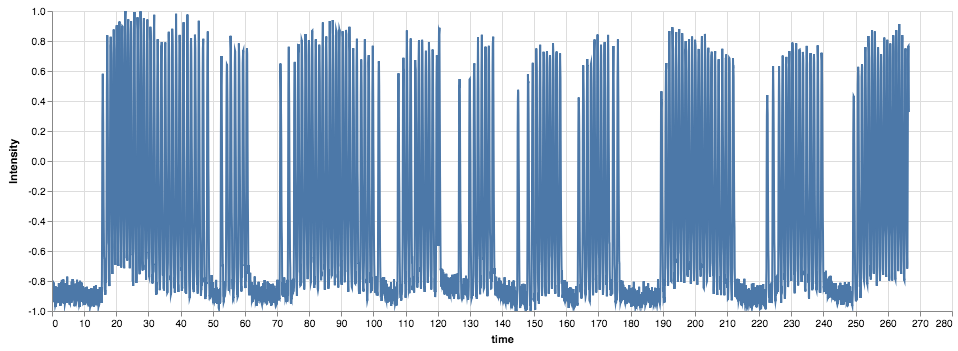

In [102]:
alt.Chart(df_tidy_roi_int[df_tidy_roi_int["ROI"]== 12],
                     width = 900, 
                     height = 300
                     ).mark_line(
                     ).encode(
                        x='time:Q',
                        y=alt.Y('normal_int:Q', 
                                axis = alt.Axis(title='Intensity'))
                     ).interactive()

In [234]:
# Given dataframe slice
def is_max(index, df):
    pre = index - 1
    post = index + 1
    if df['normal_int'].iloc[index] <=0:
        return False
    elif pre < 0:
        pre = 0
    elif post == len(df):
        post = len(df) - 1
    elif df['normal_int'].iloc[index] < df['normal_int'].iloc[pre]:
        return False
    elif df['normal_int'].iloc[index] < df['normal_int'].iloc[post]:
        return False
    else:
        return True
    
def count_max(df):
    maxima = np.empty([len(df.index)])
    for k in range(0, len(df.index)):
        sys.stdout.write("\r%.2f percent done."%(100 * k/len(df)))
        maxima[k] = is_max(df.index[k], df)
    sys.stdout.write("\r100 percent done.\n")
    df['Maxima'] = maxima
    df['Maxima'] = df['Maxima'].astype(bool)
    return

def calculate_frequency(df):
    frequency = df['Maxima'].sum() / (len(df) * .066667)
    
    return frequency

def active_frequency(df, ROI):

    temp_df = df[df['Activity'] & df['ROI'] == ROI]
    temp_df = temp_df.reset_index(level=0)
    count_max(temp_df)
    frequency = calculate_frequency(temp_df)
    
    return frequency


def calculate_period(df):
    periods = np.empty([len(df.index)])
    activity = np.empty([len(df.index)])
    for k in range(0, len(df.index)):
        sys.stdout.write("\r%.2f percent done."%(100 * k/len(df)))
        if k == 0:
            length = 0
            period = 0
            Activity = True
        if df['Maxima'].iloc[k] == True:
            period = length * .066667
            length = 0
            Activity = True
        else:
            period = 0
            length = length + 1
            if length * .066667 >= 2:
                Activity = False
            else:
                Activity = True
                
            
        periods[k] = period
        activity[k] = Activity
            
    sys.stdout.write("\r100 percent done.\n")
    df['Period'] = periods
    df['Activity'] = activity
    
def max_activity_period(df):
    df = df.reset_index(level=0)
    count_max(df)
    calculate_period(df)
    return df
    
    
    



In [235]:
df_10 = df_tidy_roi_int.loc[df_tidy_roi_int['ROI']==10]

In [236]:
max_activity_period(df_10)

100 percent done.
100 percent done.


index  ROI          mean         min          max        time Condition  \
0     40000   10  9.271574e+07  85441192.0  106288775.0    0.000000     night   
1     40001   10  9.271574e+07  85441192.0  106288775.0    0.066667     night   
2     40002   10  9.271574e+07  85441192.0  106288775.0    0.133333     night   
3     40003   10  9.271574e+07  85441192.0  106288775.0    0.200000     night   
4     40004   10  9.271574e+07  85441192.0  106288775.0    0.266667     night   
5     40005   10  9.271574e+07  85441192.0  106288775.0    0.333333     night   
6     40006   10  9.271574e+07  85441192.0  106288775.0    0.400000     night   
7     40007   10  9.271574e+07  85441192.0  106288775.0    0.466667     night   
8     40008   10  9.271574e+07  85441192.0  106288775.0    0.533333     night   
9     40009   10  9.271574e+07  85441192.0  106288775.0    0.600000     night   
10    40010   10  9.271574e+07  85441192.0  106288775.0    0.666667     night   
11    40011   10  9.271574e+07  85441192.0  106288775.0    0.733333     night   
12    40012   10  9.271574e+07  85441192.0  106288775.0    0.800000     night   
13    40013   10  9.271574e+07  85441192.0  106288775.0    0.866667     night   
14    40014   10  9.271574e+07  85441192.0  106288775.0    0.933333     night   
15    40015   10  9.271574e+07  85441192.0  106288775.0    1.000000     night   
16    40016   10  9.271574e+07  85441192.0  106288775.0    1.066667     night   
17    40017   10  9.271574e+07  85441192.0  106288775.0    1.133333     night   
18    40018   10  9.271574e+07  85441192.0  106288775.0    1.200000     night   
19    40019   10  9.271574e+07  85441192.0  106288775.0    1.266667     night   
20    40020   10  9.271574e+07  85441192.0  106288775.0    1.333333     night   
21    40021   10  9.271574e+07  85441192.0  106288775.0    1.400000     night   
22    40022   10  9.271574e+07  85441192.0  106288775.0    1.466667     night   
23    40023   10  9.271574e+07  85441192.0  106288775.0    1.533333     night   
24    40024   10  9.271574e+07  85441192.0  106288775.0    1.600000     night   
25    40025   10  9.271574e+07  85441192.0  106288775.0    1.666667     night   
26    40026   10  9.271574e+07  85441192.0  106288775.0    1.733333     night   
27    40027   10  9.271574e+07  85441192.0  106288775.0    1.800000     night   
28    40028   10  9.271574e+07  85441192.0  106288775.0    1.866667     night   
29    40029   10  9.271574e+07  85441192.0  106288775.0    1.933333     night   
...     ...  ...           ...         ...          ...         ...       ...   
3970  43970   10  9.271574e+07  85441192.0  106288775.0  264.666667     night   
3971  43971   10  9.271574e+07  85441192.0  106288775.0  264.733333     night   
3972  43972   10  9.271574e+07  85441192.0  106288775.0  264.800000     night   
3973  43973   10  9.271574e+07  85441192.0  106288775.0  264.866667     night   
3974  43974   10  9.271574e+07  85441192.0  106288775.0  264.933333     night   
3975  43975   10  9.271574e+07  85441192.0  106288775.0  265.000000     night   
3976  43976   10  9.271574e+07  85441192.0  106288775.0  265.066667     night   
3977  43977   10  9.271574e+07  85441192.0  106288775.0  265.133333     night   
3978  43978   10  9.271574e+07  85441192.0  106288775.0  265.200000     night   
3979  43979   10  9.271574e+07  85441192.0  106288775.0  265.266667     night   
3980  43980   10  9.271574e+07  85441192.0  106288775.0  265.333333     night   
3981  43981   10  9.271574e+07  85441192.0  106288775.0  265.400000     night   
3982  43982   10  9.271574e+07  85441192.0  106288775.0  265.466667     night   
3983  43983   10  9.271574e+07  85441192.0  106288775.0  265.533333     night   
3984  43984   10  9.271574e+07  85441192.0  106288775.0  265.600000     night   
3985  43985   10  9.271574e+07  85441192.0  106288775.0  265.666667     night   
3986  43986   10  9.271574e+07  85441192.0  106288775.0  265.733333     night   
3987  43987   10  9.271574e+07  85441

In [233]:
calculate_period(df_10)
df_10

100 percent done.


index  ROI          mean         min          max        time Condition  \
0     40000   10  9.271574e+07  85441192.0  106288775.0    0.000000     night   
1     40001   10  9.271574e+07  85441192.0  106288775.0    0.066667     night   
2     40002   10  9.271574e+07  85441192.0  106288775.0    0.133333     night   
3     40003   10  9.271574e+07  85441192.0  106288775.0    0.200000     night   
4     40004   10  9.271574e+07  85441192.0  106288775.0    0.266667     night   
5     40005   10  9.271574e+07  85441192.0  106288775.0    0.333333     night   
6     40006   10  9.271574e+07  85441192.0  106288775.0    0.400000     night   
7     40007   10  9.271574e+07  85441192.0  106288775.0    0.466667     night   
8     40008   10  9.271574e+07  85441192.0  106288775.0    0.533333     night   
9     40009   10  9.271574e+07  85441192.0  106288775.0    0.600000     night   
10    40010   10  9.271574e+07  85441192.0  106288775.0    0.666667     night   
11    40011   10  9.271574e+07  85441192.0  106288775.0    0.733333     night   
12    40012   10  9.271574e+07  85441192.0  106288775.0    0.800000     night   
13    40013   10  9.271574e+07  85441192.0  106288775.0    0.866667     night   
14    40014   10  9.271574e+07  85441192.0  106288775.0    0.933333     night   
15    40015   10  9.271574e+07  85441192.0  106288775.0    1.000000     night   
16    40016   10  9.271574e+07  85441192.0  106288775.0    1.066667     night   
17    40017   10  9.271574e+07  85441192.0  106288775.0    1.133333     night   
18    40018   10  9.271574e+07  85441192.0  106288775.0    1.200000     night   
19    40019   10  9.271574e+07  85441192.0  106288775.0    1.266667     night   
20    40020   10  9.271574e+07  85441192.0  106288775.0    1.333333     night   
21    40021   10  9.271574e+07  85441192.0  106288775.0    1.400000     night   
22    40022   10  9.271574e+07  85441192.0  106288775.0    1.466667     night   
23    40023   10  9.271574e+07  85441192.0  106288775.0    1.533333     night   
24    40024   10  9.271574e+07  85441192.0  106288775.0    1.600000     night   
25    40025   10  9.271574e+07  85441192.0  106288775.0    1.666667     night   
26    40026   10  9.271574e+07  85441192.0  106288775.0    1.733333     night   
27    40027   10  9.271574e+07  85441192.0  106288775.0    1.800000     night   
28    40028   10  9.271574e+07  85441192.0  106288775.0    1.866667     night   
29    40029   10  9.271574e+07  85441192.0  106288775.0    1.933333     night   
...     ...  ...           ...         ...          ...         ...       ...   
3970  43970   10  9.271574e+07  85441192.0  106288775.0  264.666667     night   
3971  43971   10  9.271574e+07  85441192.0  106288775.0  264.733333     night   
3972  43972   10  9.271574e+07  85441192.0  106288775.0  264.800000     night   
3973  43973   10  9.271574e+07  85441192.0  106288775.0  264.866667     night   
3974  43974   10  9.271574e+07  85441192.0  106288775.0  264.933333     night   
3975  43975   10  9.271574e+07  85441192.0  106288775.0  265.000000     night   
3976  43976   10  9.271574e+07  85441192.0  106288775.0  265.066667     night   
3977  43977   10  9.271574e+07  85441192.0  106288775.0  265.133333     night   
3978  43978   10  9.271574e+07  85441192.0  106288775.0  265.200000     night   
3979  43979   10  9.271574e+07  85441192.0  106288775.0  265.266667     night   
3980  43980   10  9.271574e+07  85441192.0  106288775.0  265.333333     night   
3981  43981   10  9.271574e+07  85441192.0  106288775.0  265.400000     night   
3982  43982   10  9.271574e+07  85441192.0  106288775.0  265.466667     night   
3983  43983   10  9.271574e+07  85441192.0  106288775.0  265.533333     night   
3984  43984   10  9.271574e+07  85441192.0  106288775.0  265.600000     night   
3985  43985   10  9.271574e+07  85441192.0  106288775.0  265.666667     night   
3986  43986   10  9.271574e+07  85441192.0  106288775.0  265.733333     night   
3987  43987   10  9.271574e+07  85441

In [173]:
df_tidy_roi1['normal_int'].iloc[df_tidy_roi1.index]

0      -0.837872
1      -0.859294
2      -0.771275
3      -0.444259
4       0.196573
5       0.632545
6       0.777763
7       0.781473
8       0.681486
9       0.421439
10      0.062467
11     -0.205858
12     -0.471237
13     -0.638101
14     -0.761618
15     -0.828195
16     -0.859294
17     -0.729158
18     -0.064424
19      0.568055
20      0.784214
21      0.850046
22      0.786302
23      0.576091
24      0.223514
25     -0.074231
26     -0.293895
27     -0.501161
28     -0.634055
29     -0.734062
          ...   
3970    0.329915
3971    0.021058
3972   -0.271317
3973   -0.515013
3974   -0.700018
3975   -0.817680
3976   -0.901075
3977   -0.815741
3978   -0.361983
3979    0.242754
3980    0.628648
3981    0.801087
3982    0.809551
3983    0.705630
3984    0.452556
3985    0.139728
3986   -0.167787
3987   -0.423695
3988   -0.602920
3989   -0.731097
3990   -0.855341
3991   -0.818650
3992   -0.522844
3993    0.091794
3994    0.595760
3995    0.776682
3996    0.806960
3997    0.6991

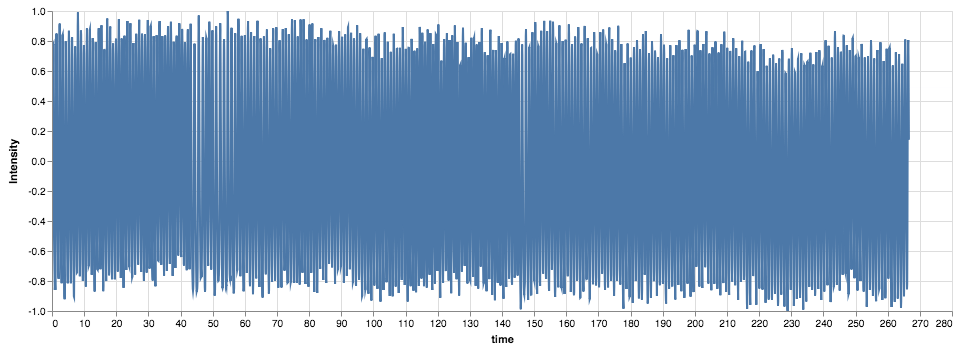

In [111]:
alt.Chart(df_tidy_roi0,
                     width = 900, 
                     height = 300
                     ).mark_line(
                     ).encode(
                        x='time:Q',
                        y=alt.Y('normal_int:Q', 
                                axis = alt.Axis(title='Intensity'))
                     ).interactive()

In [15]:
p = bokeh.plotting.figure(plot_width=850,
                          plot_height=400,
                          x_axis_label='time (s)', 
                          y_axis_label='total intensity')

# I have to store the plots in an array to creatively work with the legend
index = 0
plots = [0]*16

first = True # used to only show the first plot. 

for roi in range(0,8):
    for daytime in ["day", "night"]:
        name = "sum_int_%s_roi%i" % (daytime, roi)
        q = p.line(df_roi_intensities['time'].values, 
               df_roi_intensities[name].values, 
               line_width=2, 
               visible = first, # used to only show the first plot. 
               line_join='bevel')
        name = "ROI %i %s" % (roi, daytime)
        plots[index] = LegendItem(label=name, renderers=[q])
        # Indexing to keep track of plots array
        index += 1
        first = False # used to only show the first plot. 


legend = Legend(items=plots,
                location=(0,-20),
                click_policy = "hide")

p.add_layout(legend, 'right')
bokeh.io.show(p)